In [176]:
import os
os.environ['CASTLE_BACKEND'] = 'pytorch'

from collections import OrderedDict

import numpy as np
import networkx as nx

import castle
from castle.common import GraphDAG
from castle.metrics import MetricsDAG
from castle.datasets import IIDSimulation, DAG
from castle.algorithms import PC, GES, ICALiNGAM, GOLEM

import matplotlib.pyplot as plt

In [177]:
import pandas as pd
data_drugs_pd = pd.read_csv("/home/joe/Documents/incarceration/replication/src/data_causal_graph.csv")
data_drugs_np = data_drugs_pd.to_numpy()

In [233]:
from castle.common.priori_knowledge import PrioriKnowledge

# Add in prior knowledge, namely that the drugs variable cannot cause anything
priori = PrioriKnowledge(data_drugs_np.shape[1])

priori.add_forbidden_edges([(0, 1),
                            (0, 2),
                            (0, 3),
                            (0, 4),
                            (0, 5),
                            (0, 6)])

# Build the model
pc_drugs = PC(priori_knowledge = priori)
pc_drugs.learn(data_drugs_np)

# Print out the learned matrix
print(pc_drugs.causal_matrix)

[[0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 1 0 1 1 1 0]
 [0 1 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [1 1 0 1 1 0 0]
 [1 1 1 1 1 0 0]]


In [234]:
custom_matrix = pc_drugs.causal_matrix
custom_matrix[2, 1] = 0
custom_matrix[3, 1] = 1
custom_matrix[1, 3] = 0
custom_matrix[2, 5] = 0
custom_matrix[3, 5] = 1
custom_matrix[5, 3] = 0
custom_matrix[6, 1] = 0
custom_matrix[4, 0] = 0

In [237]:
# Get learned graph
learned_graph_drugs = nx.DiGraph(custom_matrix)

# Relabel the nodes
MAPPING = {k: v for k, v in zip(range(10), ["Drug Overdoses", "Income", "Jail", "Prison", "Homicides",
                                            "Education", "Prescription Rate"])}
learned_graph_drugs = nx.relabel_nodes(learned_graph_drugs, MAPPING, copy=True)

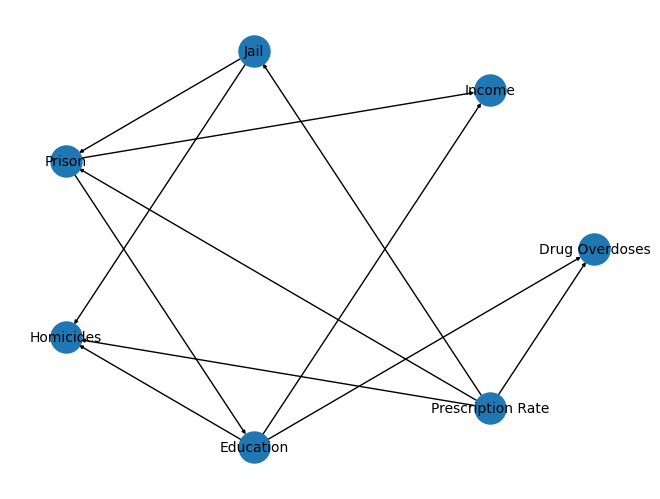

In [238]:
# Plot the graph
nx.draw(
    learned_graph_drugs,
    with_labels=True,
    node_size=500,
    font_size=10,
    arrowsize = 5,
    font_color='black',
    pos = nx.circular_layout(learned_graph_drugs)
)

In [185]:
from castle.algorithms.pc.pc import find_skeleton
skeleton, sep_set = find_skeleton(data_drugs_np, 0.05, 'fisherz', priori_knowledge=priori)
print(skeleton)
print(sep_set)

[[0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 1. 1. 0. 1. 1.]
 [0. 1. 0. 1. 1. 1. 1.]
 [0. 1. 1. 0. 0. 1. 1.]
 [1. 0. 1. 0. 0. 1. 1.]
 [1. 1. 1. 1. 1. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0.]]
{(0, 2): [6], (5, 6): [0], (0, 1): [5, 6], (0, 3): [5, 6], (1, 4): [2, 5], (3, 4): [2, 5, 6]}


In [186]:
from castle.algorithms.pc.pc import orient
equiv_class = orient(skeleton, sep_set, priori_knowledge=priori)
print(equiv_class)

[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 1. 1. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 1. 1. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0.]]


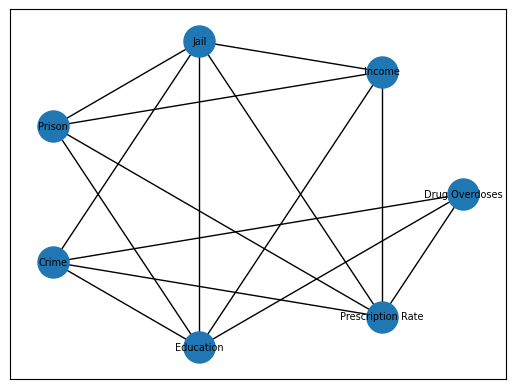

In [187]:
# Plot the graph
learned_skeleton_graph = nx.Graph(skeleton)

# Relabel the nodes
MAPPING = {k: v for k, v in zip(range(10), ["Drug Overdoses", "Income", "Jail", "Prison", "Crime",
                                            "Education", "Prescription Rate"])}
learned_skeleton_graph = nx.relabel_nodes(learned_skeleton_graph, MAPPING, copy=True)

nx.draw_networkx(
    learned_skeleton_graph, 
    with_labels=True,
    node_size=500,
    font_size=7,
    font_color='black',
    pos = nx.circular_layout(learned_skeleton_graph))

In [38]:
list(data_drugs_pd.columns)

['drugs',
 'income_lag',
 'county_jail_adm_lag',
 'county_prison_adm_lag',
 'county_crime_lag',
 'blacks_lag',
 'hispanics_lag',
 'race_other_lag',
 'log_education_lag',
 'px_lag']

In [17]:
# Let's generate the data according to Fig 2. A.
x = np.random.randn(1000)
y = np.random.randn(1000)

z = x + y + .1 * np.random.randn(1000)
w = .7 * z + .1 * np.random.randn(1000)

# To matrix
pc_dataset = np.vstack([x, y, z, w]).T

# Sanity check
print(pc_dataset.shape)

(1000, 4)


In [60]:
# Build the model
pc = PC()
pc.learn(pc_dataset)

# Print out the learned matrix
print(pc.causal_matrix)

[[0 0 0 1]
 [0 0 1 0]
 [0 1 0 1]
 [1 0 1 0]]


In [139]:
# Get learned graph
learned_graph = nx.DiGraph(pc.causal_matrix)

# Relabel the nodes
MAPPING = {k: v for k, v in zip(range(4), ['X', 'Y', 'Z', 'W'])}
learned_graph = nx.relabel_nodes(learned_graph, MAPPING, copy=True)

# Plot the graph
nx.draw(
    learned_graph, 
    with_labels=True,
    node_size=1800,
    font_size=18,
    font_color='white'
)

TypeError: '_AxesStack' object is not callable

<Figure size 640x480 with 0 Axes>

2023-04-18 23:47:51,358 - /home/joe/Documents/incarceration/incarceration/lib/python3.11/site-packages/castle/backend/__init__.py[line:36] - INFO: You can use `os.environ['CASTLE_BACKEND'] = backend` to set the backend(`pytorch` or `mindspore`).
2023-04-18 23:47:51,466 - /home/joe/Documents/incarceration/incarceration/lib/python3.11/site-packages/castle/algorithms/__init__.py[line:36] - INFO: You are using ``pytorch`` as the backend.
2023-04-18 23:47:51,489 - /home/joe/Documents/incarceration/incarceration/lib/python3.11/site-packages/castle/datasets/simulator.py[line:270] - INFO: Finished synthetic dataset
2023-04-18 23:47:51,491 - /home/joe/Documents/incarceration/incarceration/lib/python3.11/site-packages/castle/algorithms/gradient/notears/linear.py[line:195] - INFO: [start]: n=2000, d=10, iter_=100, h_=1e-08, rho_=1e+16
2023-04-18 23:47:51,602 - /home/joe/Documents/incarceration/incarceration/lib/python3.11/site-packages/castle/algorithms/gradient/notears/linear.py[line:206] - INFO

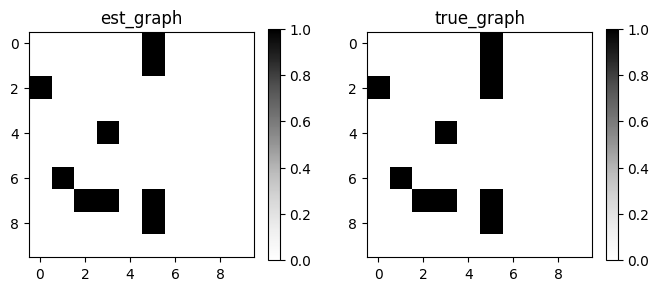

{'fdr': 0.0, 'tpr': 0.9, 'fpr': 0.0, 'shd': 1, 'nnz': 9, 'precision': 1.0, 'recall': 0.9, 'F1': 0.9474, 'gscore': 0.9}


NameError: name 'nx' is not defined

In [1]:
from castle.common import GraphDAG
from castle.metrics import MetricsDAG
from castle.datasets import IIDSimulation, DAG
from castle.algorithms import PC
from castle.algorithms import Notears

# data simulation, simulate true causal dag and train_data.
weighted_random_dag = DAG.erdos_renyi(n_nodes=10, n_edges=10, weight_range=(0.5, 2.0), seed=1)
dataset = IIDSimulation(W = weighted_random_dag, n = 2000, method = 'linear', sem_type = 'gauss')
true_causal_matrix, X = dataset.B, dataset.X

# II. Learn the Causal Structure beneath the observation data.
nt = Notears()
nt.learn(X)

# III. Visualize the comparison of estimated/true graphs using a heat map.
GraphDAG(nt.causal_matrix, true_causal_matrix)

# IV. Calculate Metrics.
mt = MetricsDAG(nt.causal_matrix, true_causal_matrix)
print(mt.metrics)

learned_graph = nx.DiGraph(nt.causal_matrix)
print(learned_graph)

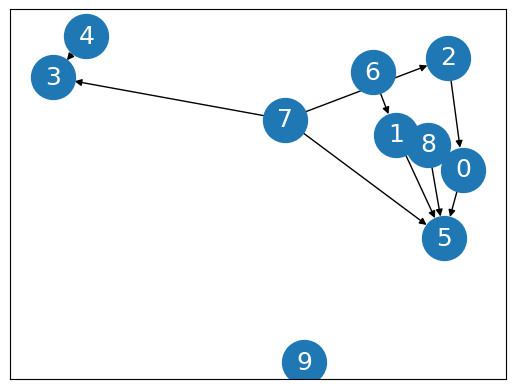

In [14]:
# Plot the graph
nx.draw_networkx(
    learned_graph, 
    with_labels=True,
    node_size=1000,
    font_size=18,
    font_color='white'
)